In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Nov 14 08:24:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
# Parameters
num_actions_train = 2500  # Number of actions/articles in training dataset
num_actions_val = 1000    # Number of actions/articles in validation dataset
T_train = 500             # Number of time periods for outcomes per action in training
T_val = 500               # Number of time periods for outcomes per action in validation

# Data generation
np.random.seed(42)  # Set random seed for reproducibility

def mix_beta(z):
    Z1, Z2 = z
    if np.random.rand() < 0.5:
        alpha, beta = 25 * Z1 + 1, 25 * (1 - Z1) + 1
    else:
        alpha, beta = 25 * (1 - Z2) + 1, 25 * Z2 + 1
    return alpha, beta

# Function to generate dataset
def generate_dataset(num_actions, T):
    # Step 1: Sample Z(a) for each action (Z1, Z2) independently from Uniform(0, 0.25)
    Z = np.random.uniform(0, 0.25, size=(num_actions, 2))

    # Step 2: Sample success rate (mu_infinity) from a mixture of Beta distributions
    mu_infinity = []
    for z in Z:
        alpha, beta = mix_beta(z)
        mu = stats.beta.rvs(alpha, beta)  # Sample from the Beta distribution
        mu_infinity.append(mu)

    mu_infinity = np.array(mu_infinity)

    # Step 3: Generate outcomes Y_t for each action based on mu_infinity
    Y = np.zeros((num_actions, T))
    for i, mu in enumerate(mu_infinity):
        Y[i, :] = np.random.binomial(1, mu, size=T)

    return Z, mu_infinity, Y

# Generate training dataset
Z_train, mu_infinity_train, Y_train = generate_dataset(num_actions_train, T_train)

# Generate validation dataset
Z_val, mu_infinity_val, Y_val = generate_dataset(num_actions_val, T_val)

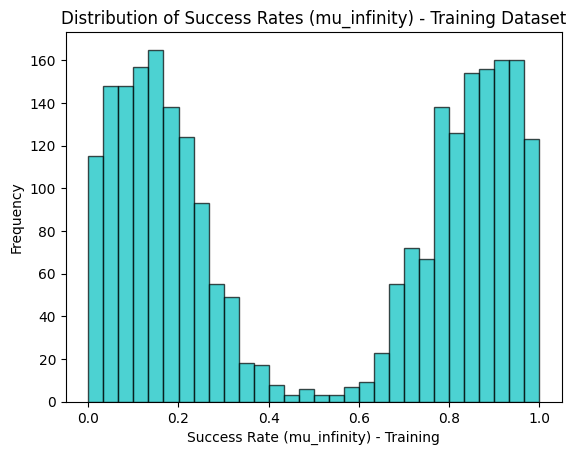

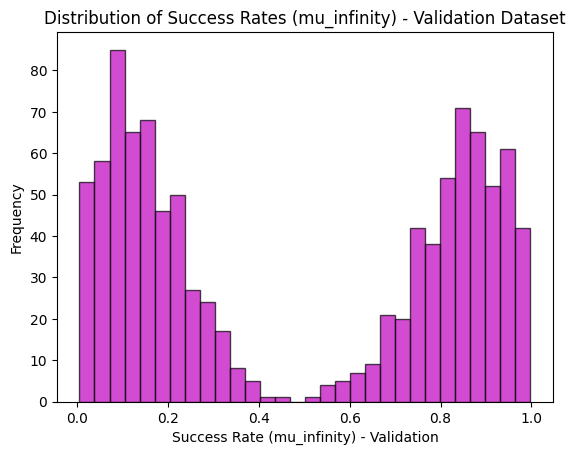

Training Action 1 (mu_infinity = 0.19): Outcomes = [1. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
Training Action 2 (mu_infinity = 0.22): Outcomes = [1. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
Training Action 3 (mu_infinity = 0.06): Outcomes = [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Training Action 4 (mu_infinity = 0.04): Outcomes = [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Training Action 5 (mu_infinity = 0.83): Outcomes = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Validation Action 1 (mu_infinity = 0.76): Outcomes = [1. 1. 1. 0. 0. 1. 1. 1. 1. 1.]
Validation Action 2 (mu_infinity = 0.87): Outcomes = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Validation Action 3 (mu_infinity = 0.12): Outcomes = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Validation Action 4 (mu_infinity = 0.15): Outcomes = [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Validation Action 5 (mu_infinity = 0.20): Outcomes = [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [5]:
# Visualizing the distribution of mu_infinity for training dataset
plt.hist(mu_infinity_train, bins=30, color='c', edgecolor='k', alpha=0.7)
plt.xlabel('Success Rate (mu_infinity) - Training')
plt.ylabel('Frequency')
plt.title('Distribution of Success Rates (mu_infinity) - Training Dataset')
plt.show()

# Visualizing the distribution of mu_infinity for validation dataset
plt.hist(mu_infinity_val, bins=30, color='m', edgecolor='k', alpha=0.7)
plt.xlabel('Success Rate (mu_infinity) - Validation')
plt.ylabel('Frequency')
plt.title('Distribution of Success Rates (mu_infinity) - Validation Dataset')
plt.show()

# Displaying some generated outcomes for training dataset
for i in range(5):
    print(f"Training Action {i+1} (mu_infinity = {mu_infinity_train[i]:.2f}): Outcomes = {Y_train[i, :10]}")

# Displaying some generated outcomes for validation dataset
for i in range(5):
    print(f"Validation Action {i+1} (mu_infinity = {mu_infinity_val[i]:.2f}): Outcomes = {Y_val[i, :10]}")

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Convert data to PyTorch tensors
Z_train_tensor = torch.tensor(Z_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Z_val_tensor = torch.tensor(Z_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)

# Define the Flexible Neural Network model
class FlexibleNN(nn.Module):
    def __init__(self, input_dim=22):
        super(FlexibleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, Z, summary_stat):
        x = torch.cat((Z, summary_stat.repeat(1, 10)), dim=1)  # Repeat the summary stat tuple 10 times
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Define the Beta-Bernoulli NN model
class BetaBernoulliNN(nn.Module):
    def __init__(self, input_dim=22):
        super(BetaBernoulliNN, self).__init__()
        self.alpha_mlp = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
            nn.ReLU()
        )
        self.beta_mlp = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
            nn.ReLU()
        )

        # Initialize bias terms to 1 to avoid starting with Beta parameters of value 0
        for layer in [self.alpha_mlp[-2], self.beta_mlp[-2]]:
            nn.init.constant_(layer.bias, 1.0)

    def forward(self, Z, summary_stat):
        x = torch.cat((Z, summary_stat.repeat(1, 10)), dim=1)  # Repeat the summary stat tuple 10 times
        alpha = self.alpha_mlp(x)
        beta = self.beta_mlp(x)
        # return alpha / (alpha + beta)
        return alpha, beta, alpha / (alpha + beta)

In [9]:
# Training phase modification with new loss function
def train_autoregressive_model(model, train_loader, optimizer, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # Move model to GPU if available
    model.train()  # Set the model to training mode

    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for Z_batch, Y_batch in train_loader:
            # Move data to GPU if available
            Z_batch, Y_batch = Z_batch.to(device), Y_batch.to(device)

            # Initialize total loss for the batch
            tot_loss = 0.0

            # Sequentially calculate the loss for each time step t
            for t in range(1, Y_batch.shape[1] + 1):
                # Get the sequence of previous outcomes up to time t-1
                if t == 1:
                    previous_outcomes = torch.zeros((Y_batch.shape[0], 1), device=device)  # No previous outcomes at t=1
                else:
                    previous_outcomes = Y_batch[:, :t-1]

                # Compute summary statistics (mean, 1 / (1 + N_a)) based on previous outcomes
                stat_1 = previous_outcomes.mean(dim=1, keepdim=True)
                stat_2 = torch.tensor([1 / t] * previous_outcomes.shape[0], device=device).reshape(-1, 1)
                summary_stat_t = torch.cat((stat_1, stat_2), dim=1)

                # Forward pass to get model outputs
                # outputs = model(Z_batch, summary_stat_t)
                _, _, outputs = model(Z_batch, summary_stat_t)

                # Compute the log-probability for the current time step t
                Y_t = Y_batch[:, t-1].unsqueeze(1)
                log_probs = Y_t * torch.log(outputs + 1e-9) + (1 - Y_t) * torch.log(1 - outputs + 1e-9)

                # Accumulate negative log-likelihood
                tot_loss += -torch.sum(log_probs)

            # Backward pass and optimization
            optimizer.zero_grad()
            tot_loss.backward()
            optimizer.step()

            running_loss += tot_loss.item()

        # Print loss for every 100 epochs
        if (epoch + 1) % 100 == 0:
            avg_loss = running_loss / len(train_loader)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    print("Training completed.")


In [10]:
batch_size = 500          # Batch size for training
learning_rate = 0.001     # Learning rate for optimizer
epochs = 1000             # Number of epochs for training
weight_decay = 0.01       # Weight decay for AdamW optimizer

In [ ]:
# # Initialize the model, loss function, and optimizer
# model = FlexibleNN()
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# train_dataset = TensorDataset(Z_train_tensor, Y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# train_autoregressive_model(model, train_loader, optimizer, epochs)

 10%|█         | 100/1000 [05:15<47:22,  3.16s/it]

Epoch [100/1000], Loss: 99769.2297


 20%|██        | 200/1000 [10:31<42:03,  3.15s/it]

Epoch [200/1000], Loss: 99526.0328


 30%|███       | 300/1000 [15:48<36:54,  3.16s/it]

Epoch [300/1000], Loss: 99489.5516


 40%|████      | 400/1000 [21:04<32:00,  3.20s/it]

Epoch [400/1000], Loss: 99381.8031


 50%|█████     | 500/1000 [26:20<26:48,  3.22s/it]

Epoch [500/1000], Loss: 99078.4625


 60%|██████    | 600/1000 [31:37<20:55,  3.14s/it]

Epoch [600/1000], Loss: 99012.3344


 70%|███████   | 700/1000 [36:51<15:49,  3.16s/it]

Epoch [700/1000], Loss: 98985.0922


 80%|████████  | 800/1000 [42:06<10:27,  3.14s/it]

Epoch [800/1000], Loss: 98991.2203


 90%|█████████ | 900/1000 [47:22<05:12,  3.12s/it]

Epoch [900/1000], Loss: 98948.3500


100%|██████████| 1000/1000 [52:38<00:00,  3.16s/it]

Epoch [1000/1000], Loss: 98931.5719
Training completed.


In [ ]:
# # Save the model state dictionary after training
# model_save_path = "/content/drive/My Drive/flexible_nn_model.pth"
# torch.save(model.state_dict(), model_save_path)

In [11]:
# Initialize the model, loss function, and optimizer
model = BetaBernoulliNN()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_dataset = TensorDataset(Z_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_autoregressive_model(model, train_loader, optimizer, epochs)

 10%|█         | 100/1000 [07:15<1:05:09,  4.34s/it]

Epoch [100/1000], Loss: 98918.3203


 20%|██        | 200/1000 [14:29<57:46,  4.33s/it]

Epoch [200/1000], Loss: 98870.8828


 30%|███       | 300/1000 [21:43<50:46,  4.35s/it]

Epoch [300/1000], Loss: 98848.7250


 40%|████      | 400/1000 [28:59<43:49,  4.38s/it]

Epoch [400/1000], Loss: 98828.1484


 50%|█████     | 500/1000 [36:15<36:14,  4.35s/it]

Epoch [500/1000], Loss: 98815.9312


 60%|██████    | 600/1000 [43:29<28:50,  4.33s/it]

Epoch [600/1000], Loss: 98817.6609


 70%|███████   | 700/1000 [50:43<21:33,  4.31s/it]

Epoch [700/1000], Loss: 98894.8750


 80%|████████  | 800/1000 [57:57<14:21,  4.31s/it]

Epoch [800/1000], Loss: 98851.5188


 90%|█████████ | 900/1000 [1:05:09<07:11,  4.32s/it]

Epoch [900/1000], Loss: 98822.1625


100%|██████████| 1000/1000 [1:12:23<00:00,  4.34s/it]

Epoch [1000/1000], Loss: 98805.5938
Training completed.


In [12]:
# Save the model state dictionary after training
model_save_path = "/content/drive/My Drive/BetaBernoulli_nn_model_TS.pth"
torch.save(model.state_dict(), model_save_path)